# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [4]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import os

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2017 from the CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [6]:
year = "2017"
years = [2017]

# Ensure the directory exists
os.makedirs(f"models/{year}", exist_ok=True)

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 316174


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [8]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
57386,20170313075428PD,6613898,5/14/2021 12:00:00 AM,P170720208,2,3/13/2017 12:00:00 AM,3/13/2017 12:00:00 AM,07:09:30,415,DISTURBANCE,N,No report required; dispatch r,[900]-[1000] SARATOGA AV,San Jose,CA,37.317539,-121.974537,Cypress
190847,20170812184405PD,6812288,5/14/2021 12:00:00 AM,P172240657,1,8/12/2017 12:00:00 AM,8/12/2017 12:00:00 AM,16:35:05,211SA,STRONG ARM ROBBERY,R,Report taken,[1900]-[2000] ABORN RD,San Jose,CA,37.310188,-121.811938,La Vey
105428,20170508151630PD,6685564,5/14/2021 12:00:00 AM,P171280535,2,5/8/2017 12:00:00 AM,5/8/2017 12:00:00 AM,14:48:34,1033A,"ALARM, AUDIBLE",N,No report required; dispatch r,[200]-[300] PACKING PL,San Jose,CA,37.354086,-121.842380,Mayfair
303785,20171217105457PS,6981321,5/14/2021 12:00:00 AM,P173510369,3,12/17/2017 12:00:00 AM,12/17/2017 12:00:00 AM,10:54:00,1033A,"ALARM, AUDIBLE",NR,No Response,[3400]-[3500] HOSTETTER RD,San Jose,CA,37.388583,-121.881648,Brokaw
286732,20171128084733PS,6955599,5/14/2021 12:00:00 AM,P173320149,3,11/28/2017 12:00:00 AM,11/28/2017 12:00:00 AM,06:48:04,602PC,TRESPASSING,G,Gone on Arrival/unable to loca,[2100]-[2200] N 1ST ST,San Jose,CA,37.377344,-121.920234,Trimble Business Area


In [10]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316174 entries, 0 to 316173
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              316174 non-null  object 
 1   EID               316174 non-null  int64  
 2   START_DATE        316174 non-null  object 
 3   CALL_NUMBER       316174 non-null  object 
 4   PRIORITY          316174 non-null  int64  
 5   REPORT_DATE       316174 non-null  object 
 6   OFFENSE_DATE      316174 non-null  object 
 7   OFFENSE_TIME      316174 non-null  object 
 8   CALLTYPE_CODE     316174 non-null  object 
 9   CALL_TYPE         316127 non-null  object 
 10  FINAL_DISPO_CODE  316174 non-null  object 
 11  FINAL_DISPO       316174 non-null  object 
 12  ADDRESS           305672 non-null  object 
 13  CITY              316174 non-null  object 
 14  STATE             316174 non-null  object 
 15  LATITUDE          284108 non-null  float64
 16  LONGITUDE         28

In [14]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.161740e+05,316174.000000,284108.000000,284108.000000
mean,6.763769e+06,3.200130,37.319867,-121.871048
std,1.360640e+05,1.333373,0.043069,0.048089
min,6.526536e+06,1.000000,37.155151,-122.035696
25%,6.646298e+06,2.000000,37.294827,-121.902172
50%,6.764162e+06,3.000000,37.323313,-121.869186
75%,6.880947e+06,4.000000,37.348205,-121.837718
max,7.000037e+06,6.000000,37.534539,-121.684849


In [16]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,316174,316174,316174,316174,316174,316174,316174,316127,316174,316174,305672,316174,316174,282657
unique,313958,1,306282,365,365,81206,220,213,22,18,31333,1,1,295
top,20171207103853PS,5/14/2021 12:00:00 AM,P172681035,7/4/2017 12:00:00 AM,7/4/2017 12:00:00 AM,22:35:42,415,DISTURBANCE,N,No report required; dispatch r,[2100]-[2200] MONTEREY RD,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,316174,6,1187,1187,18,31040,31036,125971,125971,1223,316174,316174,8435


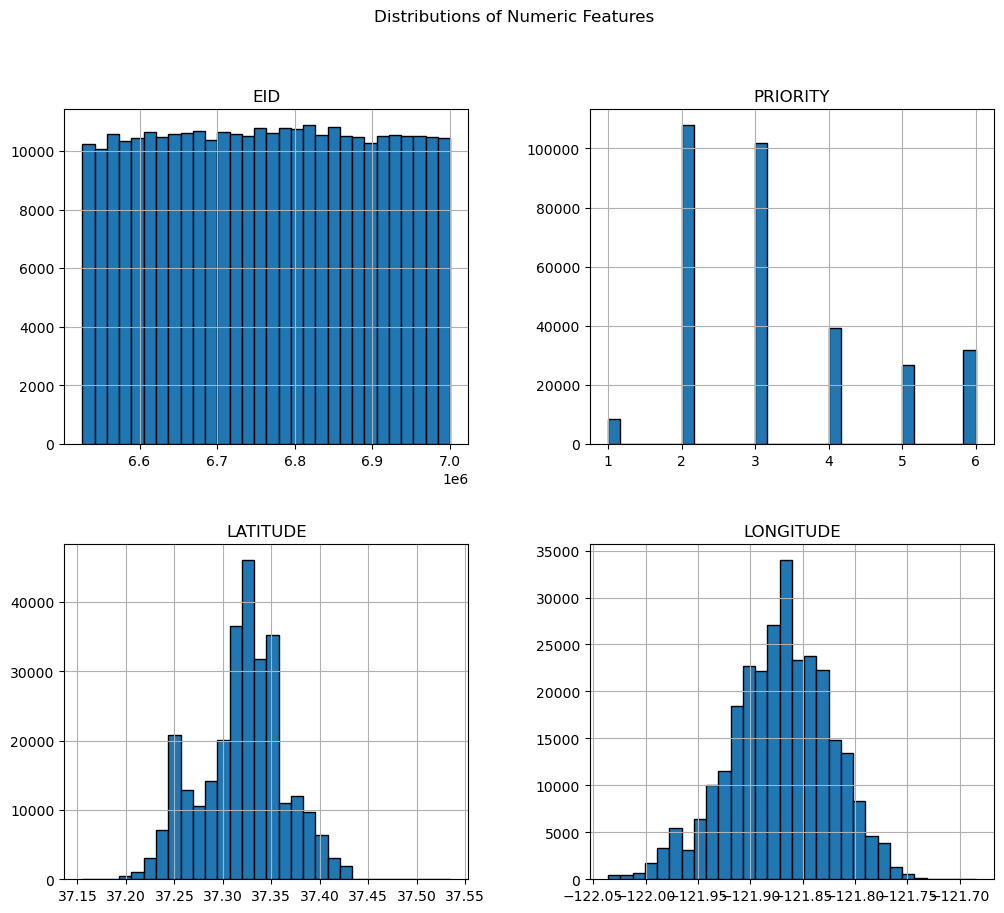

In [18]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [20]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE              47
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS             10502
CITY                    0
STATE                   0
LATITUDE            32066
LONGITUDE           32066
neighborhood        33517
dtype: int64

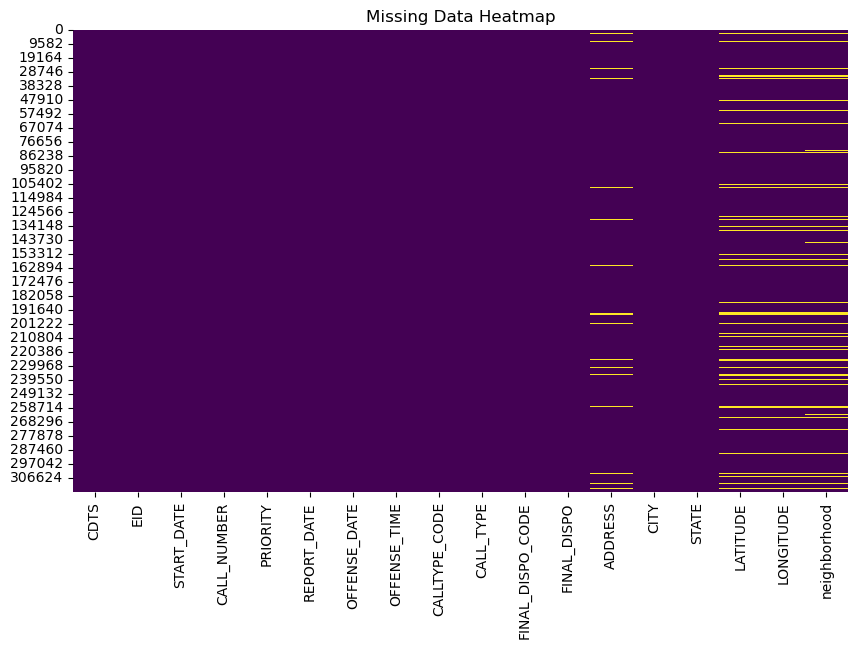

In [22]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [23]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 313958 unique values
START_DATE: 1 unique values
CALL_NUMBER: 306282 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 81206 unique values
CALLTYPE_CODE: 220 unique values
CALL_TYPE: 213 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31333 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [24]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8435
Little Saigon and Spring Brook    5285
Five Wounds-San Jose High         4782
Trimble Business Area             4541
Fruitdale and Sherman Oaks        4346
                                  ... 
Villages                            56
Linda Vista and Hillcrest           45
Meadowlands                         44
Alta Vista                          26
Santa Teresa Hills                  18
Name: count, Length: 295, dtype: int64

In [25]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          125971
CAN         51475
R           37329
NR          22402
G           19294
E            8628
D            7956
GD           7046
A            6054
DUPNCAN      5778
O            4635
H            4323
T            3731
C            3554
B            2893
ADV          2299
U            1713
F             875
M             111
P              60
Z              40
TOT             7
Name: count, dtype: int64

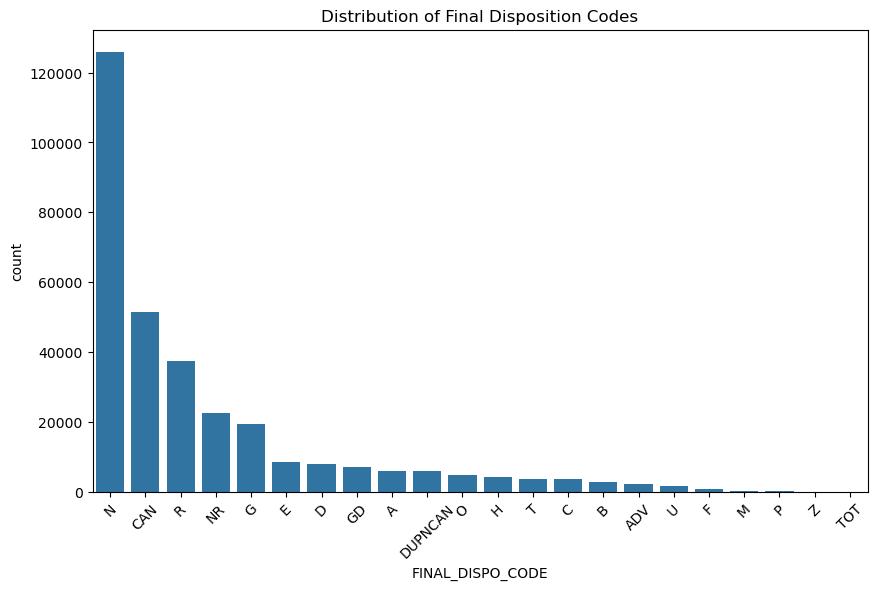

In [26]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [27]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    125971
Canceled                           51475
Report taken                       37329
No Response                        22402
Gone on Arrival/unable to loca     19294
No Disposition                     15170
Traffic Citation Issued, Non-H      8628
Traffic Citation Issued, Hazar      7956
Arrest Made                         6054
Supplemental report taken           4635
Courtesy Service/Citizen or ag      4323
Turned over To (TOT)                3731
Criminal Citation                   3554
Arrest by Warrant                   2893
Unfounded event                     1713
Field Interview (F.I.) Complet       875
Stranded motorist assist             111
Prior case, follow-up activity        60
Name: count, dtype: int64

In [28]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'CAN': 'Canceled',
 'N': 'No report required; dispatch r',
 'NR': 'No Response',
 'DUPNCAN': 'No Disposition',
 'GD': 'No Disposition',
 'G': 'Gone on Arrival/unable to loca',
 'T': 'Turned over To (TOT)',
 'H': 'Courtesy Service/Citizen or ag',
 'B': 'Arrest by Warrant',
 'R': 'Report taken',
 'U': 'Unfounded event',
 'A': 'Arrest Made',
 'O': 'Supplemental report taken',
 'E': 'Traffic Citation Issued, Non-H',
 'C': 'Criminal Citation',
 'D': 'Traffic Citation Issued, Hazar',
 'F': 'Field Interview (F.I.) Complet',
 'ADV': 'No Disposition',
 'M': 'Stranded motorist assist',
 'P': 'Prior case, follow-up activity',
 'Z': 'No Disposition',
 'TOT': 'No Disposition'}

In [30]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1057': 'FIREARMS DISCHARGED',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '602PC': 'TRESPASSING',
 '1066': 'SUSPICIOUS PERSON',
 '415F': 'DISTURBANCE, FAMILY',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '22500': 'PARKING VIOLATION',
 '415': 'DISTURBANCE',
 '10851': 'STOLEN VEHICLE',
 'FNDPRP': 'FOUND PROPERTY',
 '415A': 'DISTURBANCE, FIGHT',
 '1033A': 'ALARM, AUDIBLE',
 '242': 'BATTERY',
 'WELCK': 'WELFARE CHECK',
 '23103': 'RECKLESS DRIVING',
 '415M': 'DISTURBANCE, MUSIC',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 '1080': 'EXPLOSION',
 '1195': 'VEHICLE STOP',
 '1125': 'TRAFFIC HAZARD',
 '23110': 'THROWING SUBSTANCES AT VEHICLE',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '6M': 'MISDEMEANOR WANT',
 '422': 'CRIMINAL THREATS',
 '415WEMS': 'DISTURBANCE, WEAPON (COMBINED ',
 '1095': 'PEDESTRIAN STOP',
 '1066X': 'SUSPICIOUS FEMALE',
 '1053': 'PERSON DOWN',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '911CELL': 'UNK TYPE 911 CALL FROM CELL',
 '10851R': 'RECOVERED STOLEN VEHICLE',
 '1154': 'SUSPICIOUS VE

## Focus on Target Dispositions

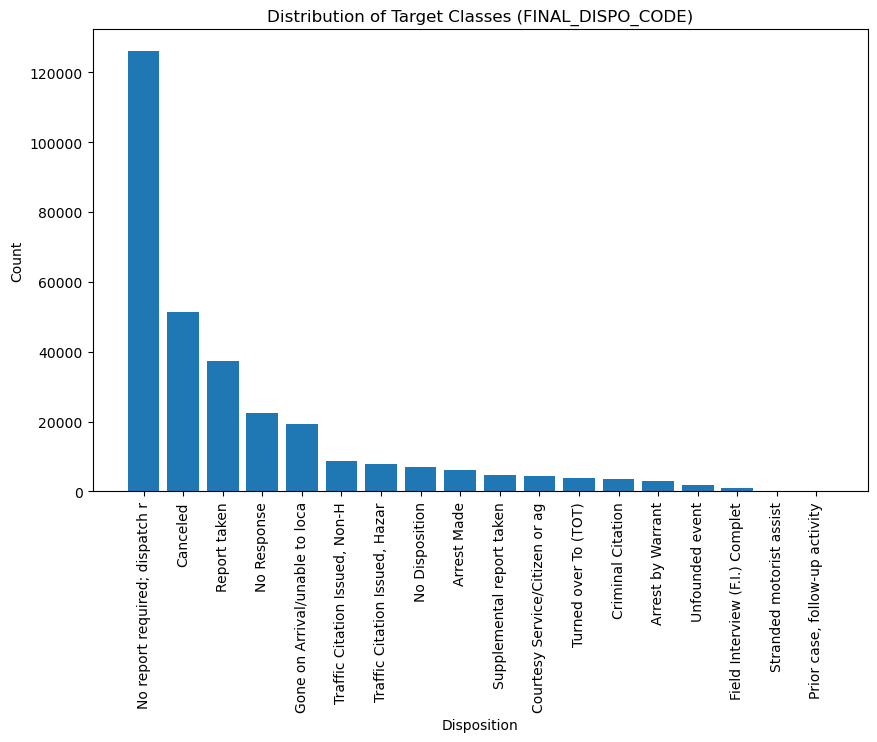

In [39]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [41]:
model_utils.transform_offense_date(all_police_df)

In [43]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    303673
A          6054
C          3554
B          2893
Name: count, dtype: int64

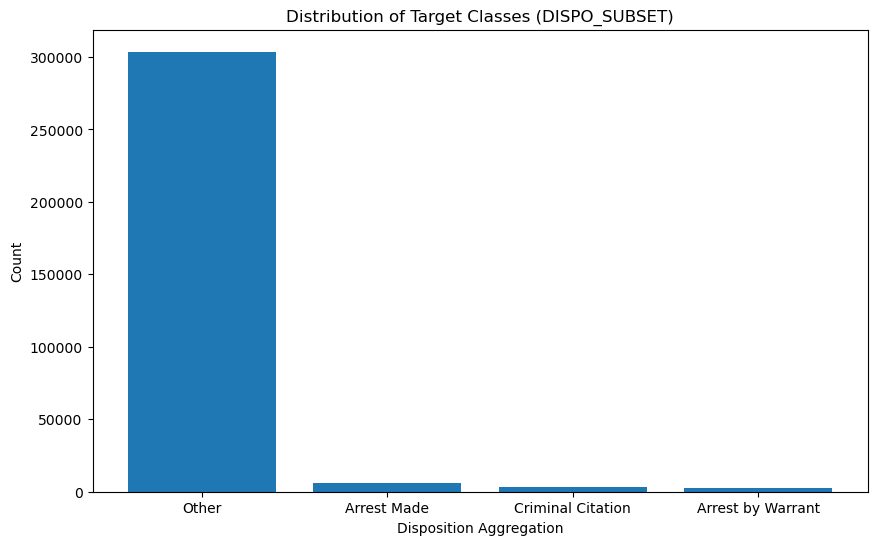

In [45]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [48]:
encoder = joblib.load('one_hot_encoder.pkl')

In [50]:
police_calls_encoded, _ = model_utils.clean_and_transform_data(all_police_df, encoder)
police_calls_encoded.shape

Police Calls Dataset: 316174 rows before cleaning, 282617 rows after cleaning.


(282617, 535)

## Define X and Y

In [52]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(226093, 534)
(56524, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 217045, 0: 4397, 2: 2564, 1: 2087})
Counter({3: 9048, 0: 4397, 2: 2564, 1: 2087})


y_train distribution: Counter({3: 217045, 0: 4397, 2: 2564, 1: 2087})
y_test distribution: Counter({3: 54262, 0: 1099, 2: 641, 1: 522})
y_train_resampled distribution: Counter({3: 217045, 0: 4397, 2: 2564, 1: 2087})


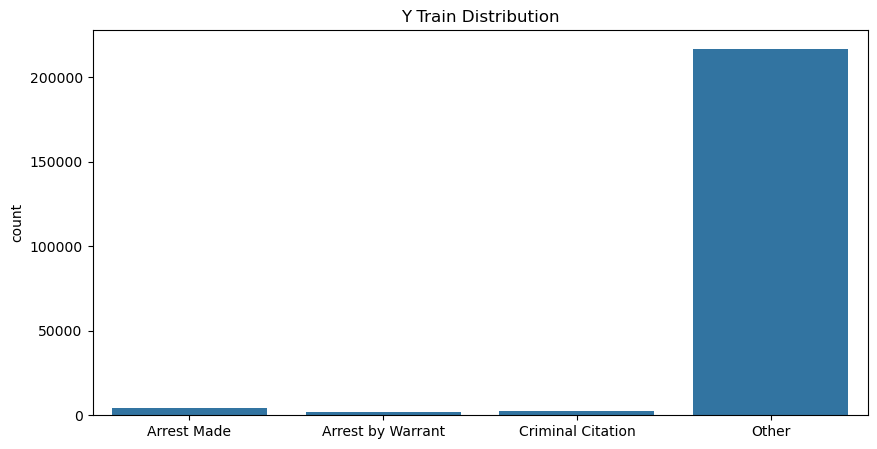

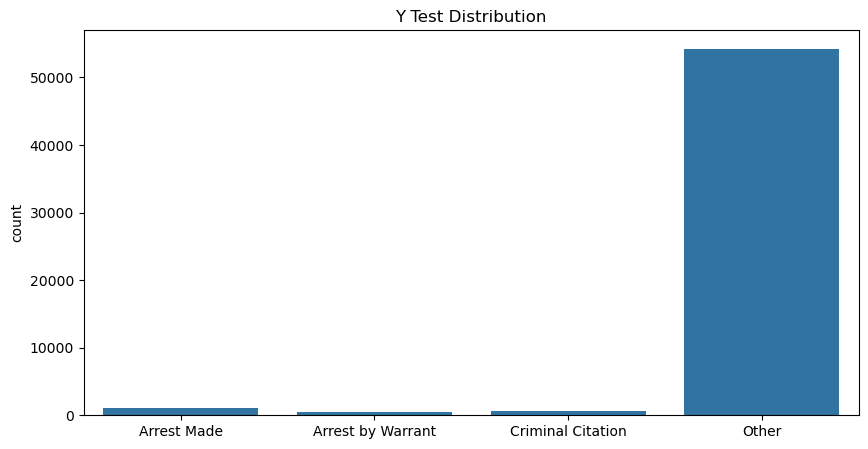

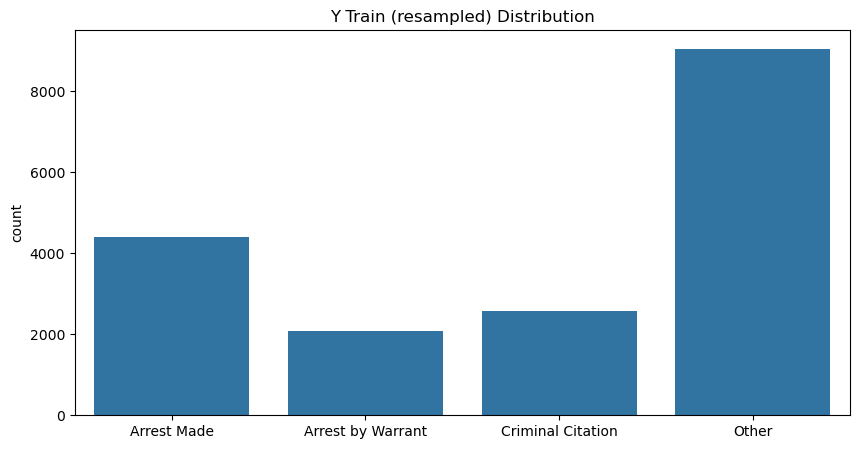

In [53]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [57]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [58]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [60]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1099
Arrest by Warrant       0.00      0.00      0.00       522
Criminal Citation       0.00      0.00      0.00       641
            Other       0.96      1.00      0.98     54262

         accuracy                           0.96     56524
        macro avg       0.24      0.25      0.24     56524
     weighted avg       0.92      0.96      0.94     56524



### Logistic Regression

In [66]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [67]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [68]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.17      0.65      0.27      1099
Arrest by Warrant       0.44      0.69      0.54       522
Criminal Citation       0.13      0.46      0.20       641
            Other       0.99      0.90      0.94     54262

         accuracy                           0.88     56524
        macro avg       0.43      0.68      0.49     56524
     weighted avg       0.96      0.88      0.92     56524



#### Hyperparameter Tuning

In [70]:
grid_search_scoring_method = 'f1_macro'

In [71]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [72]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 0.1}
Best Score (f1_macro): 0.5852


In [73]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2017/best_logistic_regression.pkl']

In [74]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [75]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.57      0.30      0.39      1099
Arrest by Warrant       0.75      0.68      0.71       522
Criminal Citation       0.50      0.17      0.25       641
            Other       0.98      0.99      0.98     54262

         accuracy                           0.97     56524
        macro avg       0.70      0.53      0.58     56524
     weighted avg       0.96      0.97      0.96     56524



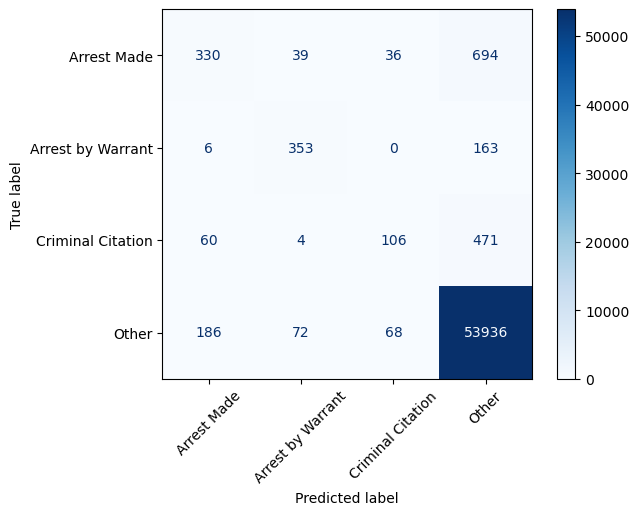

In [76]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [82]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [83]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [84]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                    Feature  Importance  \
205                        CALLTYPE_CODE_6M    0.006134   
204                        CALLTYPE_CODE_6F    0.003096   
189                      CALLTYPE_CODE_601T    0.002271   
69                      CALLTYPE_CODE_11377    0.002271   
64                      CALLTYPE_CODE_11300    0.002064   
170                       CALLTYPE_CODE_484    0.001917   
112                     CALLTYPE_CODE_23152    0.001710   
89                      CALLTYPE_CODE_14601    0.001651   
49                     CALLTYPE_CODE_10851R    0.001327   
72                      CALLTYPE_CODE_11550    0.001091   
13                      CALLTYPE_CODE_1033A    0.000826   
119                       CALLTYPE_CODE_242    0.000678   
180                      CALLTYPE_CODE_5150    0.000649   
85                      CALLTYPE_CODE_12020    0.000619   
193                     CALLTYPE_CODE_602PC    0.000531   
231                      CALLTYPE_CODE_DVRO    0.000531 

In [85]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                      Display Name  Coefficient
49             Call Type: RECOVERED STOLEN VEHICLE     0.390005
13                       Call Type: ALARM, AUDIBLE    -0.354185
107                   Call Type: PARKING VIOLATION    -0.295812
189                       Call Type: TRUANT (TABS)     0.286453
81               Call Type: VEHICLE STOP ON FEMALE    -0.272975
112                     Call Type: MISDEMEANOR DUI     0.252392
180           Call Type: MENTALLY DISTURBED PERSON     0.222118
146                 Call Type: DISTURBANCE, FAMILY     0.210016
47                       Call Type: STOLEN VEHICLE     0.191075
231       Call Type: VIOLATION OF PROTECTIVE ORDER     0.182973
63                       Call Type: TRAFFIC HAZARD    -0.166950
77       Call Type: VEHICLE ACCIDENT, PROPERTY DAM    -0.157249
201                     Call Type: DRUNK IN PUBLIC     0.150617
485  neighborhood_Stripe Elementary and Great Oaks    -0.141421
185                

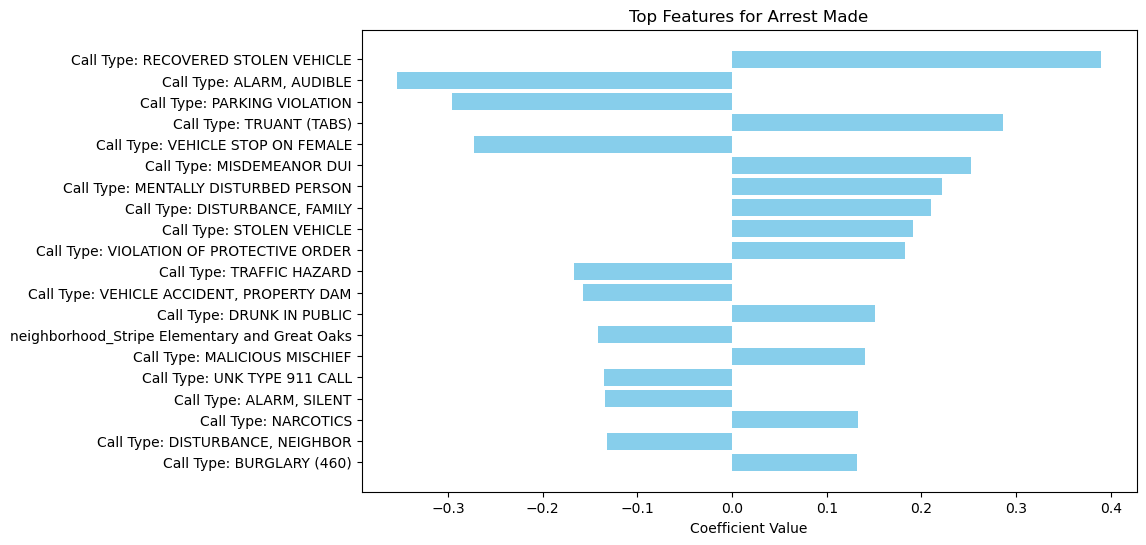

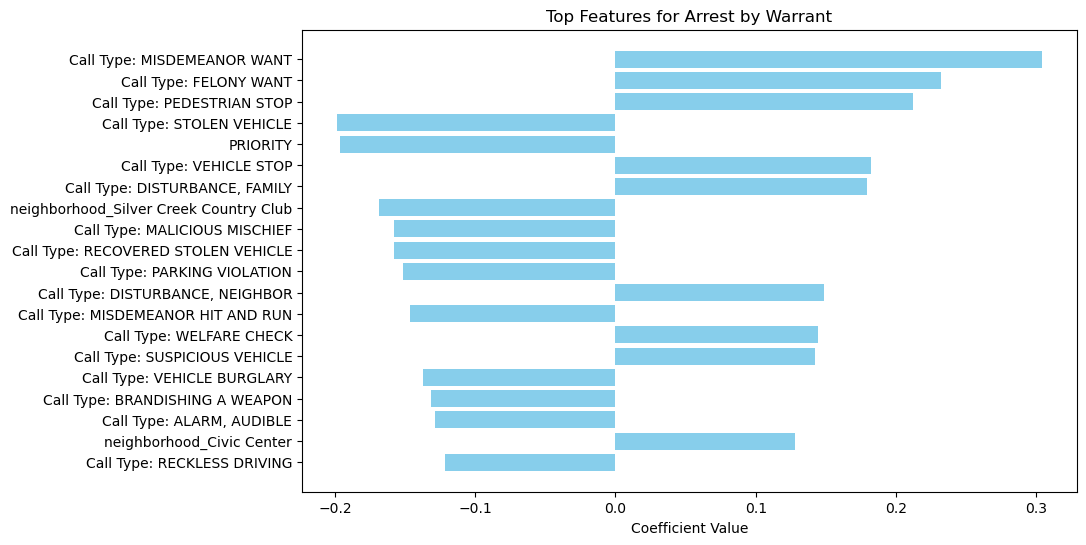

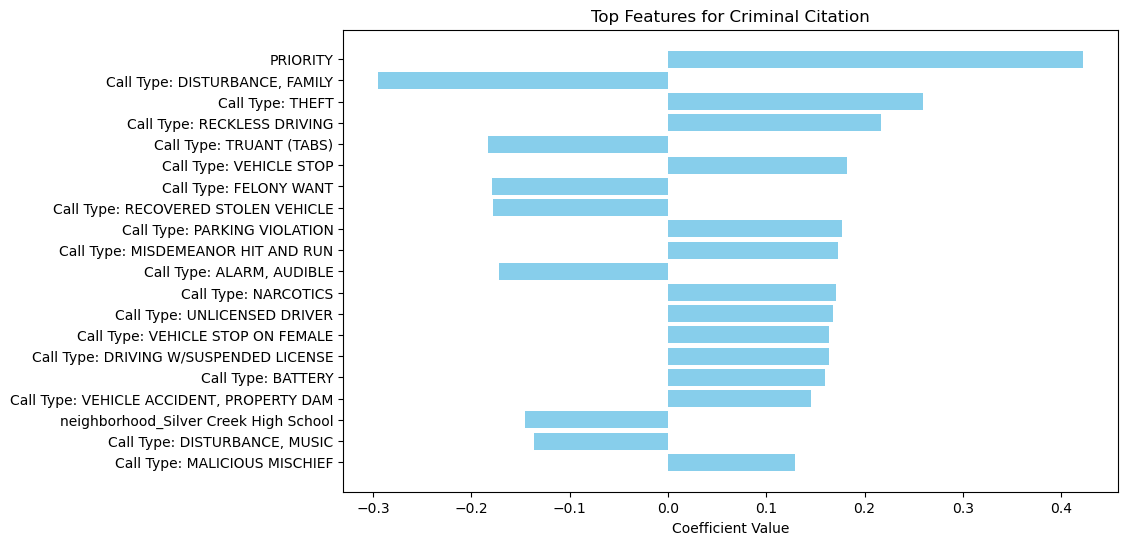

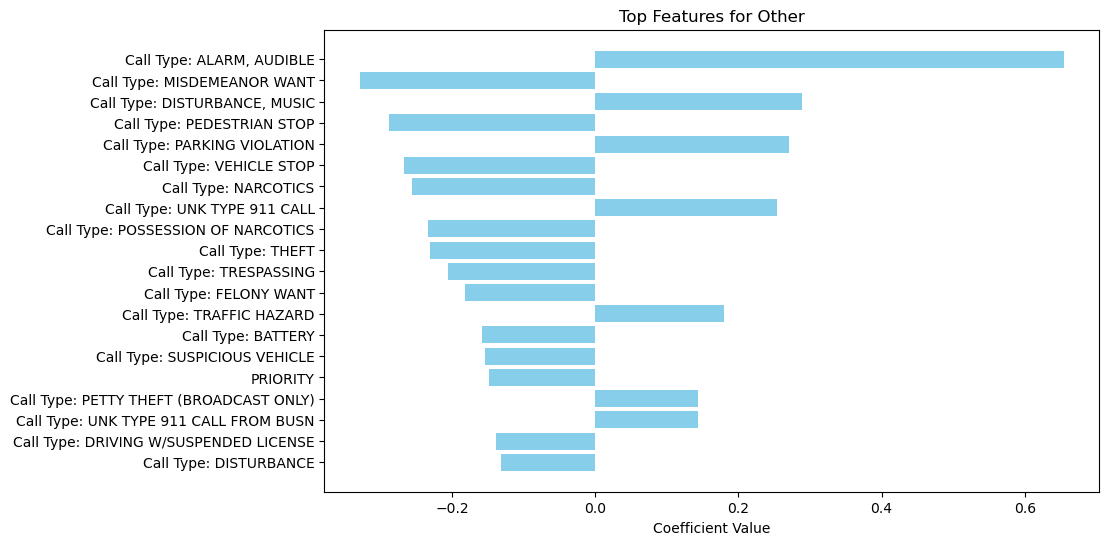

In [86]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [88]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [89]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.53      0.29      0.38      1099
Arrest by Warrant       0.69      0.64      0.66       522
Criminal Citation       0.41      0.22      0.29       641
            Other       0.98      0.99      0.98     54262

         accuracy                           0.97     56524
        macro avg       0.65      0.53      0.58     56524
     weighted avg       0.96      0.97      0.96     56524



#### Hyperparameter Tuning and Cross Validation

In [91]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=5,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.58


In [92]:
best_rf = grid_rf.best_estimator_

In [93]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2017/best_random_forest.pkl']

In [94]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [95]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.54      0.29      0.38      1099
Arrest by Warrant       0.70      0.65      0.68       522
Criminal Citation       0.43      0.24      0.31       641
            Other       0.98      0.99      0.98     54262

         accuracy                           0.97     56524
        macro avg       0.66      0.54      0.59     56524
     weighted avg       0.96      0.97      0.96     56524



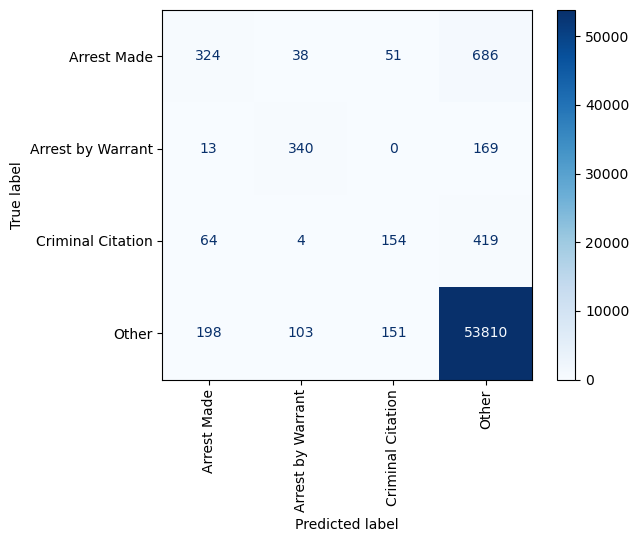

In [96]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

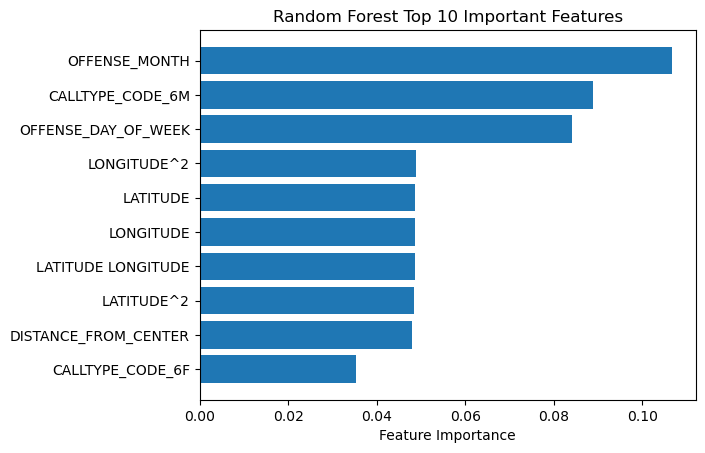

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [100]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [101]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [102]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [103]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9586 - loss: 0.1804 - val_accuracy: 0.9673 - val_loss: 0.1207
Epoch 2/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9672 - loss: 0.1257 - val_accuracy: 0.9689 - val_loss: 0.1174
Epoch 3/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9677 - loss: 0.1192 - val_accuracy: 0.9689 - val_loss: 0.1189
Epoch 4/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9672 - loss: 0.1186 - val_accuracy: 0.9690 - val_loss: 0.1184
Epoch 5/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9679 - loss: 0.1143 - val_accuracy: 0.9691 - val_loss: 0.1174
Epoch 6/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9681 - loss: 0.1111 - val_accuracy: 0.9685 - val_loss: 0.1207
Epoch 7/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9688 - loss: 0.1069 - val_accuracy: 0.9694 - val_loss: 0.1213
Epoch 8/20
2827/2827 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9695 - loss: 0.1049 - 

In [104]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2017/mlp_model.pkl']

In [105]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [106]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - accuracy: 0.9672 - loss: 0.1235
Test Accuracy: 0.9668


In [107]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.61      0.17      0.26      1099
Arrest by Warrant       0.76      0.67      0.71       522
Criminal Citation       0.35      0.15      0.21       641
            Other       0.97      1.00      0.98     54262

         accuracy                           0.97     56524
        macro avg       0.67      0.50      0.54     56524
     weighted avg       0.96      0.97      0.96     56524



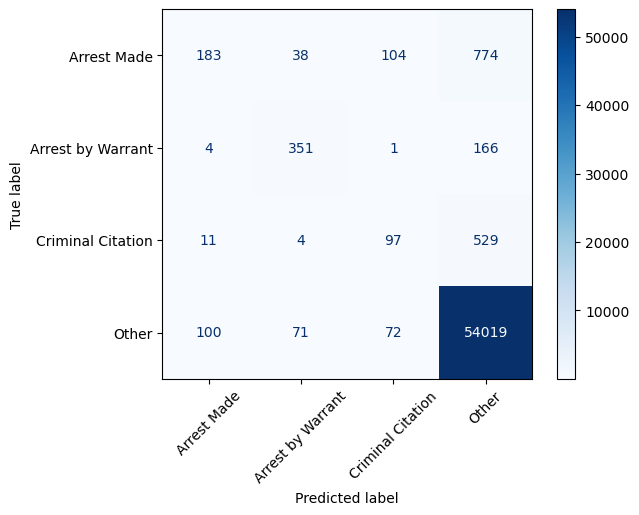

In [108]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [111]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-04 11:15:40,631] A new study created in memory with name: no-name-dee77cff-7319-4175-a069-e85281bde969
[I 2024-10-04 11:16:10,134] Trial 0 finished with value: 0.6671472598014185 and parameters: {'n_estimators': 293, 'learning_rate': 0.005226950771206795, 'max_depth': 10, 'subsample': 0.9966565392151627, 'colsample_bytree': 0.7102630822511621, 'gamma': 0.04992942259945352, 'reg_alpha': 0.02337289011814086, 'reg_lambda': 2.8462755711632658e-06}. Best is trial 0 with value: 0.6671472598014185.
[I 2024-10-04 11:16:17,834] Trial 1 finished with value: 0.639303453206329 and parameters: {'n_estimators': 101, 'learning_rate': 0.0012909049867039894, 'max_depth': 6, 'subsample': 0.6648356464464248, 'colsample_bytree': 0.8676196503728953, 'gamma': 8.682930313446582e-08, 'reg_alpha': 1.1887948152268205e-08, 'reg_lambda': 0.028528154570445826}. Best is trial 0 with value: 0.6671472598014185.
[I 2024-10-04 11:16:40,931] Trial 2 finished with value: 0.6724045211998526 and parameters: {'n_

Actual runtime: 506.39 seconds (8.44 minutes)
Best parameters found:  {'n_estimators': 352, 'learning_rate': 0.08644734728572018, 'max_depth': 5, 'subsample': 0.8564058688895129, 'colsample_bytree': 0.9616365287831617, 'gamma': 0.0005667867686691464, 'reg_alpha': 3.684626573526732e-05, 'reg_lambda': 0.002057290722223138}
Best F1 macro score:  0.7039384885238787


In [112]:
# Train the final model with the best parameters:
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)
xgb_1_model = best_model
xgb_1_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9616365287831617, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.0005667867686691464, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08644734728572018, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=352, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [113]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.58      0.30      0.40      1099
Arrest by Warrant       0.75      0.68      0.71       522
Criminal Citation       0.51      0.19      0.28       641
            Other       0.98      0.99      0.99     54262

         accuracy                           0.97     56524
        macro avg       0.71      0.54      0.59     56524
     weighted avg       0.96      0.97      0.96     56524



In [114]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2017/xgb_model.pkl']

In [115]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [117]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [118]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5849429995901049
RF F1: 0.5875101384436049
XGB F1: 0.5937386214104636


In [119]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [121]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=5)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9616365287831617,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                              learning_rate=0.08644734728572018,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=352, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(), n_jobs=5)

In [122]:
joblib.dump(stacking_clf, f"models/{year}/stacking_1.pkl") 

['models/2017/stacking_1.pkl']

In [123]:
stacking_clf = joblib.load(f"models/{year}/stacking_1.pkl")

In [124]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.596232557737612


#### Stacking #2

In [126]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=5)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9616365287831617,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=5)

In [127]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2017/stacking_2.pkl']

In [128]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [129]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.6069477680933265


## Results

In [131]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.959982,0.250000,0.239995,0.244896
Logistic Regression,0.968173,0.533969,0.700504,0.584943
Random Forest,0.966457,0.544519,0.662847,0.587510
MLP,0.966846,0.496444,0.674525,0.542595
XGB,0.968916,0.540654,0.707521,0.593739
Stack 1,0.968792,0.542413,0.703591,0.596233
Stack 2,0.969110,0.557023,0.700760,0.606948


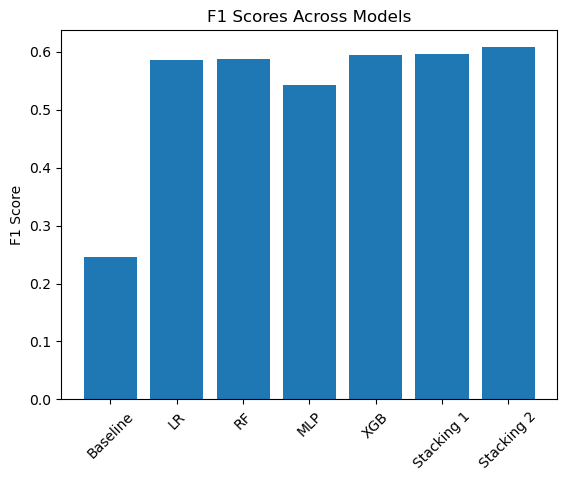

In [132]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Compare with the All-Year Models

In [134]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [135]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

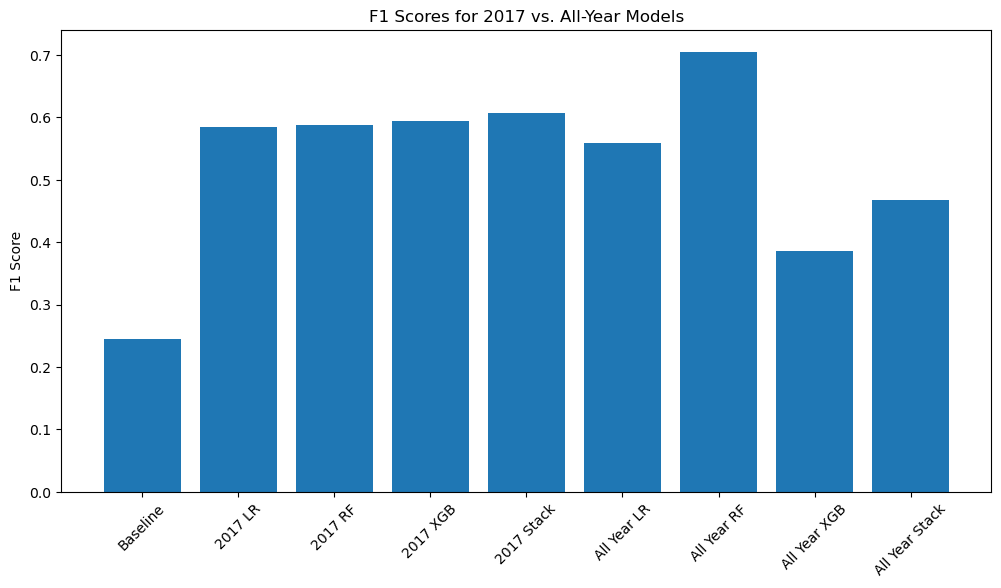

In [187]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()